In [ ]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Part 1: Backpropagation in Neural Networks

#### Overview
Artificial Neural Networks are computational learning systems that uses a network of functions to understand and translate a data input of one form into a desired output, usually in another form. The concept of the artificial neural network was inspired by human biology and the way neurons of the human brain function together to understand inputs from human senses.

A simple neural network consists of Input Layer, Hidden Layer and Output Layer.
To train these the network, we will use Backpropagation algorithm.  Backpropagation is the cornerstone of modern neural networks. To understand the algorithm in details, here is a mathematical description in the Chapter 2 of *How the backpropagation algorithm works from Neural Networks and Deep Learning* (http://neuralnetworksanddeeplearning.com/chap2.html).

In this part, you are required to implement the following architecture and write training code of a neural network from scratch using the numpy library alone.

Architecture Definition :

*   An Input Layer with the following 2-dimensions:
  *  0: Batch Size
  *  1: 784 = 28*28 pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units

There are five major steps to the implementation:

1. Define neural network: initialize_network()

2. Forward Propagation: pre_activation(), sigmoid_activation(), forward_propagation()

3. Backpropagation: backward_propagate_error()

4. Loss function and updation of weights (SGD): update_weights()

5. Training: train()


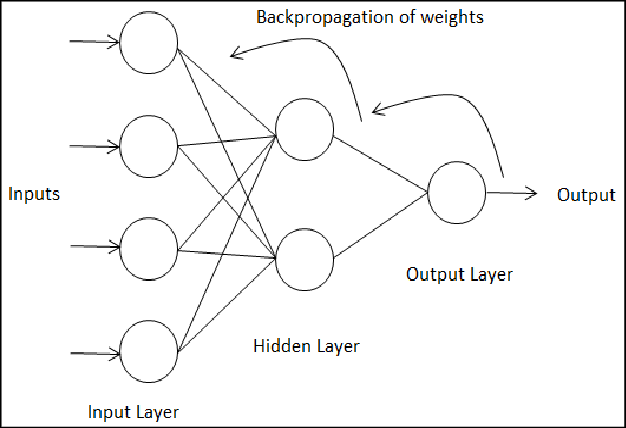



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 11SpETIc56PReKuaUKEwWDvdkiynyyGFA
!unzip "/content/MNISTArchive.zip" -d "/content/"
!gzip -d "/content/t10k-labels-idx1-ubyte.gz"
!gzip -d "/content/t10k-images-idx3-ubyte.gz"
!gzip -d "/content/train-labels-idx1-ubyte.gz"
!gzip -d "/content/train-images-idx3-ubyte.gz"

A
A
A
A
Downloading...
From: https://drive.google.com/uc?id=11SpETIc56PReKuaUKEwWDvdkiynyyGFA
To: /content/MNISTArchive.zip
100% 11.6M/11.6M [00:00<00:00, 79.0MB/s]
Archive:  /content/MNISTArchive.zip
  inflating: /content/t10k-labels-idx1-ubyte.gz  
  inflating: /content/__MACOSX/._t10k-labels-idx1-ubyte.gz  
  inflating: /content/t10k-images-idx3-ubyte.gz  
  inflating: /content/__MACOSX/._t10k-images-idx3-ubyte.gz  
  inflating: /content/train-labels-idx1-ubyte.gz  
  inflating: /content/__MACOSX/._train-labels-idx1-ubyte.gz  
  inflating: /content/train-images-idx3-ubyte.gz  
  inflating: /content/__MACOSX/._train-images-idx3-ubyte.gz  


## Helper Functions:

### Code

In [ ]:
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [ ]:
def read_mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [ ]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs, hidden_dim=500,scale=0.5):
	network = list()

	hidden_layer = {}
	hidden_layer['w'] = np.random.normal(size=(n_inputs, hidden_dim), scale=scale)
	hidden_layer['b'] = np.zeros(hidden_dim)
	network.append(hidden_layer)

	for _ in range(n_hidden):
		hidden_layer = {}
		hidden_layer['w'] = np.random.normal(size=(hidden_dim, hidden_dim), scale=scale)
		hidden_layer['b'] = np.zeros(hidden_dim)
		network.append(hidden_layer)

	hidden_layer = {}
	hidden_layer['w'] = np.random.normal(size=(hidden_dim, 50), scale=scale)
	# hidden_layer['w'] = np.random.uniform(-1., 1., size=(500, 50)) / np.sqrt(500 * 50)
	hidden_layer['b'] = np.zeros(50)
	network.append(hidden_layer)

	output_layer = {}
	output_layer['w'] = np.random.normal(size=(50, n_outputs), scale=scale)
	# output_layer['w'] = np.random.uniform(-1., 1., size=(50, n_outputs)) / np.sqrt(50 * n_outputs)
	output_layer['b'] = np.zeros(n_outputs)
	## Write your code. Initialize output_layer layer here.
	network.append(output_layer)
	return network

In [ ]:
# Calculate neuron activation for an input
def pre_activation(weights, inputs):
	activation = inputs
	for i in range(len(weights)-1):
		## Write code here. compute activation: Wx+b
		activation = np.dot(activation, weights[i]['w'])
		activation += weights[i]['b']

	return activation

def sigmoid_activation(activation):
	activation = np.clip(activation, -500, 500)
	out_sigmoid = 1 / (1 + np.exp(-activation))
	## write code. implement sigmoid function
	return out_sigmoid

# Calculate the derivative of a neuron output
def sigmoid_derivative(output):
	## write code. implement sigmoid function
	out_sigmoid_deriv = sigmoid_activation(output) * (1 - sigmoid_activation(output))
	return out_sigmoid_deriv

In [ ]:
from tqdm import tqdm

# Forward Propagation:
def forward_propagation(network, row):
	inputs = row
	for layer in network:
		## write you code here.
		## for each hidden neuron this 'layer', compute \
		## pre_activation, sigmoid_activation and save then output in 'new_inputs.'
		pre_activation = np.dot(inputs, layer['w'])
		pre_activation += layer['b']
		layer['pre_actv'] = pre_activation

		post_activation = sigmoid_activation(pre_activation)
		layer['output'] = post_activation
		layer['input'] = inputs

		inputs = post_activation

	return inputs

# Backpropagation:
def backward_propagate_error(network, ground_truth):
	ground_truth = np.array(ground_truth)
	prev_d = None
	for i in reversed(range(len(network))):
		layer = network[i]
		# errors = list()
		if i != len(network)-1:
			## write your code here.
			## compute error for all the hidden layer and append it to errors to keep track.
			pass
		else:
			## write your code here.
			## compute error for the output layer using ground_truth and append it to errors to keep track.
			# prev_d = -(np.divide(ground_truth, network[i]['output']) - np.divide(1 - ground_truth, 1 - network[i]['output']))
			prev_d = 2 * (network[i]['output'] - ground_truth)

		prev_d = prev_d * sigmoid_derivative(network[i]['output'])
		network[i]['db'] = np.mean(prev_d, axis=0)
		network[i]['dw'] = np.dot(network[i]['input'].T, prev_d)
		prev_d = np.dot(prev_d, network[i]['w'].T)

# Stochastic GD for weight updation:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		# if i != 0:
			## write your code here.
			## pass activation i.e. neuron['output'] from previous layer as input to current layer 'i'
		network[i]['w'] -= l_rate * network[i]['dw'] / len(row)
		network[i]['b'] -= l_rate * network[i]['db'] / len(row)

		# for neuron in network[i]:
		# 	for j in range(len(inputs)):
		# 		## write you code here.
		# 		## update the weights between each input and each neuron.
		# 		pass

		# 	## write you code here.
		# 	## update the bias vector
		# 	pass

# Train a network for a fixed number of epochs
def train(network, x, y, l_rate, n_epoch, n_outputs, bs=1, x_test=None, y_test=None):
	accs = []
	for epoch in range(n_epoch):
		p = np.random.permutation(len(x))
		x = x[p]
		y = y[p]

		sum_error = 0

		for i in tqdm(range(len(x) // bs + 1)):
			x_i = x[i*bs:(i+1)*bs]
			y_i = y[i*bs:(i+1)*bs]
			outputs = forward_propagation(network, x_i)

			if len(y_i.shape) == 1:
				expected = np.zeros(outputs.shape)
				expected[range(len(expected)), y_i.astype(int)] = 1
			else:
				expected = y_i

			sum_error += ((expected-outputs)**2).mean()
			backward_propagate_error(network, expected)
			update_weights(network, x_i, l_rate)

		if x_test is None:
			acc = cal_acc(network, x, y, bs=bs)
		else:
			acc = cal_acc(network, x_test, y_test, bs=bs)
		accs.append(acc)
		print('>epoch=%d, lrate=%.3f, error=%.3f, acc=%.3f' % (epoch, l_rate, sum_error / (len(x) // bs + 1), acc))

	return accs

def cal_acc(network, test_images, test_labels, bs=1):
	predictions = []

	for i in range(len(test_images) // bs + 1):
		x_i = test_images[i*bs:(i+1)*bs]
		outputs = forward_propagation(network, x_i)
		predictions += list(outputs)

	predictions = np.array(predictions)

	if len(test_labels.shape) == 1:
		predicions_correct = predictions.argmax(axis=1) == test_labels
	else:
		predicions_correct = predictions.argmax(axis=1) == test_labels.argmax(axis=1)
	accuracy = predicions_correct.mean()

	return accuracy

100%|██████████| 3/3 [00:00<00:00, 765.52it/s]


>epoch=0, lrate=0.100, error=0.306, acc=0.500


100%|██████████| 3/3 [00:00<00:00, 1364.45it/s]


>epoch=1, lrate=0.100, error=0.219, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 705.76it/s]


>epoch=2, lrate=0.100, error=0.108, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 621.84it/s]


>epoch=3, lrate=0.100, error=0.086, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 509.64it/s]


>epoch=4, lrate=0.100, error=0.085, acc=0.800


100%|██████████| 3/3 [00:00<00:00, 847.45it/s]


>epoch=5, lrate=0.100, error=0.078, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 874.12it/s]


>epoch=6, lrate=0.100, error=0.056, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 875.58it/s]


>epoch=7, lrate=0.100, error=0.065, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 738.56it/s]


>epoch=8, lrate=0.100, error=0.049, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 885.37it/s]


>epoch=9, lrate=0.100, error=0.046, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 910.75it/s]


>epoch=10, lrate=0.100, error=0.038, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 914.32it/s]


>epoch=11, lrate=0.100, error=0.039, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1018.03it/s]


>epoch=12, lrate=0.100, error=0.035, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1039.14it/s]


>epoch=13, lrate=0.100, error=0.046, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 99.27it/s]


>epoch=14, lrate=0.100, error=0.026, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 854.47it/s]


>epoch=15, lrate=0.100, error=0.023, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 956.95it/s]


>epoch=16, lrate=0.100, error=0.019, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1192.47it/s]


>epoch=17, lrate=0.100, error=0.028, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1182.94it/s]


>epoch=18, lrate=0.100, error=0.019, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1136.26it/s]


>epoch=19, lrate=0.100, error=0.019, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1174.88it/s]


>epoch=20, lrate=0.100, error=0.017, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1146.30it/s]


>epoch=21, lrate=0.100, error=0.018, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1227.24it/s]


>epoch=22, lrate=0.100, error=0.015, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1062.30it/s]


>epoch=23, lrate=0.100, error=0.012, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1122.37it/s]


>epoch=24, lrate=0.100, error=0.015, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 982.04it/s]


>epoch=25, lrate=0.100, error=0.011, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1162.72it/s]


>epoch=26, lrate=0.100, error=0.009, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1105.70it/s]


>epoch=27, lrate=0.100, error=0.011, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1009.05it/s]


>epoch=28, lrate=0.100, error=0.009, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 980.13it/s]


>epoch=29, lrate=0.100, error=0.012, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 917.12it/s]


>epoch=30, lrate=0.100, error=0.011, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 965.39it/s]


>epoch=31, lrate=0.100, error=0.010, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 915.39it/s]


>epoch=32, lrate=0.100, error=0.008, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 967.69it/s]


>epoch=33, lrate=0.100, error=0.008, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1026.76it/s]


>epoch=34, lrate=0.100, error=0.006, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 947.22it/s]


>epoch=35, lrate=0.100, error=0.007, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 982.81it/s]


>epoch=36, lrate=0.100, error=0.008, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1009.70it/s]


>epoch=37, lrate=0.100, error=0.005, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 985.89it/s]


>epoch=38, lrate=0.100, error=0.005, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1054.82it/s]


>epoch=39, lrate=0.100, error=0.007, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1046.74it/s]


>epoch=40, lrate=0.100, error=0.006, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1051.47it/s]


>epoch=41, lrate=0.100, error=0.005, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1040.68it/s]


>epoch=42, lrate=0.100, error=0.006, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 589.03it/s]


>epoch=43, lrate=0.100, error=0.005, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1038.37it/s]


>epoch=44, lrate=0.100, error=0.004, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1049.10it/s]


>epoch=45, lrate=0.100, error=0.005, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1055.97it/s]


>epoch=46, lrate=0.100, error=0.004, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1061.49it/s]


>epoch=47, lrate=0.100, error=0.005, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1049.63it/s]


>epoch=48, lrate=0.100, error=0.006, acc=1.000


100%|██████████| 3/3 [00:00<00:00, 1037.77it/s]


>epoch=49, lrate=0.100, error=0.005, acc=1.000


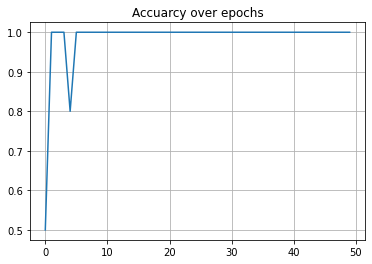

In [ ]:
# 1. Test your code for backprop algorithm on this sample dataset.
seed(1)
sample_dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]
sample_dataset = np.array(sample_dataset)
np.random.shuffle(sample_dataset)
x = sample_dataset[:, :-1]
y = sample_dataset[:, -1]

n_inputs = len(sample_dataset[0]) - 1
n_outputs = len(set([sample[-1] for sample in sample_dataset]))
network = initialize_network(n_inputs, 0, n_outputs, scale=0.5)
acc = train(network, x, y, l_rate=0.1, n_epoch=50, n_outputs=n_outputs, bs=4)
#for layer in network:
 #print(layer)
plt.figure()
plt.title('Accuarcy over epochs')
plt.grid()
plt.plot(np.arange(50), acc)

Downloaded train-images-idx3-ubyte.gz to /content/
Downloaded train-labels-idx1-ubyte.gz to /content/
Downloaded t10k-images-idx3-ubyte.gz to /content/
Downloaded t10k-labels-idx1-ubyte.gz to /content/
(60000, 784) (60000, 10)


100%|██████████| 938/938 [00:10<00:00, 93.39it/s]


>epoch=0, lrate=0.010, error=0.091, acc=0.522


100%|██████████| 938/938 [00:12<00:00, 77.62it/s]


>epoch=1, lrate=0.010, error=0.067, acc=0.667


100%|██████████| 938/938 [00:09<00:00, 94.86it/s]


>epoch=2, lrate=0.010, error=0.057, acc=0.719


100%|██████████| 938/938 [00:09<00:00, 96.27it/s]


>epoch=3, lrate=0.010, error=0.051, acc=0.756


100%|██████████| 938/938 [00:09<00:00, 95.48it/s]


>epoch=4, lrate=0.010, error=0.048, acc=0.786


100%|██████████| 938/938 [00:09<00:00, 100.63it/s]


>epoch=5, lrate=0.010, error=0.045, acc=0.802


100%|██████████| 938/938 [00:09<00:00, 94.59it/s]


>epoch=6, lrate=0.010, error=0.042, acc=0.809


100%|██████████| 938/938 [00:09<00:00, 95.59it/s] 


>epoch=7, lrate=0.010, error=0.039, acc=0.821


100%|██████████| 938/938 [00:09<00:00, 96.11it/s]


>epoch=8, lrate=0.010, error=0.037, acc=0.826


100%|██████████| 938/938 [00:09<00:00, 95.65it/s] 


>epoch=9, lrate=0.010, error=0.035, acc=0.829

Train Accuracy: 0.8293666666666667

Test Accuracy: 0.8351


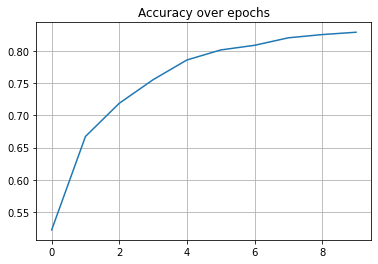

In [ ]:
## Apply 3 hidden layers:

# Read MNIST data
train_images, train_labels, test_images, test_labels = read_mnist(path='/content/')
print(train_images.shape, train_labels.shape)

# Run Backpropagation.
# Write you code here.
n_inputs = len(train_images[0])
n_outputs = 10
network = initialize_network(n_inputs, 1, n_outputs, hidden_dim=256, scale=0.5)
acc = train(network, train_images, train_labels, l_rate=0.01, n_epoch=10, n_outputs=n_outputs, bs=64)
plt.figure()
plt.title('Accuracy over epochs')
plt.grid()
plt.plot(np.arange(10), acc)

accuracy = cal_acc(network, train_images, train_labels, bs=10240)
print()
print(f'Train Accuracy: {accuracy}')

accuracy = cal_acc(network, test_images, test_labels, bs=10240)
print()
print(f'Test Accuracy: {accuracy}')

(60000, 784) (60000, 10)


100%|██████████| 938/938 [00:11<00:00, 80.66it/s] 


>epoch=0, lrate=0.010, error=0.086, acc=0.549


100%|██████████| 938/938 [00:08<00:00, 104.42it/s]


>epoch=1, lrate=0.010, error=0.068, acc=0.634


100%|██████████| 938/938 [00:08<00:00, 105.25it/s]


>epoch=2, lrate=0.010, error=0.060, acc=0.665


100%|██████████| 938/938 [00:11<00:00, 81.90it/s]


>epoch=3, lrate=0.010, error=0.054, acc=0.695


100%|██████████| 938/938 [00:10<00:00, 88.41it/s] 


>epoch=4, lrate=0.010, error=0.050, acc=0.721


100%|██████████| 938/938 [00:09<00:00, 95.83it/s] 


>epoch=5, lrate=0.010, error=0.046, acc=0.750


100%|██████████| 938/938 [00:09<00:00, 98.21it/s] 


>epoch=6, lrate=0.010, error=0.043, acc=0.772


100%|██████████| 938/938 [00:09<00:00, 98.50it/s] 


>epoch=7, lrate=0.010, error=0.040, acc=0.782


100%|██████████| 938/938 [00:10<00:00, 92.51it/s] 


>epoch=8, lrate=0.010, error=0.038, acc=0.787


100%|██████████| 938/938 [00:11<00:00, 84.49it/s] 


>epoch=9, lrate=0.010, error=0.038, acc=0.791

Train Accuracy: 0.7908333333333334

Test Accuracy: 0.7896


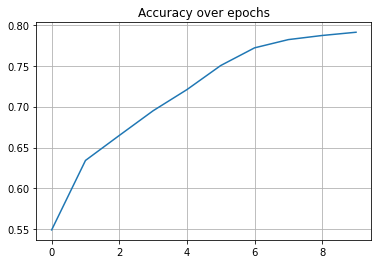

In [ ]:
## Apply 4 hidden layers:

# Read MNIST data
train_images, train_labels, test_images, test_labels = read_mnist(path='/content/')
print(train_images.shape, train_labels.shape)

# Run Backpropagation.
# Write you code here.
n_inputs = len(train_images[0])
n_outputs = 10
network = initialize_network(n_inputs, 2, n_outputs, hidden_dim=256, scale=0.5)
acc = train(network, train_images, train_labels, l_rate=0.01, n_epoch=10, n_outputs=n_outputs, bs=64)
plt.figure()
plt.title('Accuracy over epochs')
plt.grid()
plt.plot(np.arange(10), acc)

accuracy = cal_acc(network, train_images, train_labels, bs=10240)
print()
print(f'Train Accuracy: {accuracy}')

accuracy = cal_acc(network, test_images, test_labels, bs=10240)
print()
print(f'Test Accuracy: {accuracy}')

(60000, 784) (60000, 10)


100%|██████████| 938/938 [00:15<00:00, 60.25it/s]


>epoch=0, lrate=0.010, error=0.087, acc=0.497


100%|██████████| 938/938 [00:15<00:00, 61.68it/s]


>epoch=1, lrate=0.010, error=0.070, acc=0.592


100%|██████████| 938/938 [00:24<00:00, 37.85it/s]


>epoch=2, lrate=0.010, error=0.060, acc=0.647


100%|██████████| 938/938 [00:20<00:00, 46.80it/s]


>epoch=3, lrate=0.010, error=0.054, acc=0.676


100%|██████████| 938/938 [00:19<00:00, 49.31it/s]


>epoch=4, lrate=0.010, error=0.050, acc=0.698


100%|██████████| 938/938 [00:15<00:00, 59.26it/s]


>epoch=5, lrate=0.010, error=0.046, acc=0.716


100%|██████████| 938/938 [00:21<00:00, 43.38it/s]


>epoch=6, lrate=0.010, error=0.043, acc=0.733


100%|██████████| 938/938 [00:23<00:00, 40.60it/s]


>epoch=7, lrate=0.010, error=0.041, acc=0.749


100%|██████████| 938/938 [00:21<00:00, 44.49it/s]


>epoch=8, lrate=0.010, error=0.039, acc=0.776


100%|██████████| 938/938 [00:16<00:00, 56.30it/s]


>epoch=9, lrate=0.010, error=0.037, acc=0.785

Train Accuracy: 0.7845833333333333

Test Accuracy: 0.7895


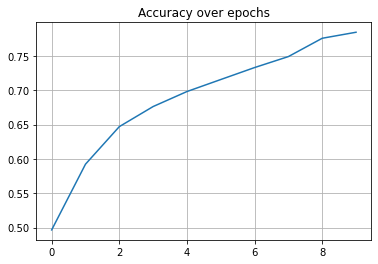

In [ ]:
#Apply 5 hidden layers
# Read MNIST data
train_images, train_labels, test_images, test_labels = read_mnist(path='/content/')
print(train_images.shape, train_labels.shape)

# Run Backpropagation.
# Write you code here.
n_inputs = len(train_images[0])
n_outputs = 10
network = initialize_network(n_inputs,3, n_outputs, hidden_dim=256, scale=0.5)
acc = train(network, train_images, train_labels, l_rate=0.01, n_epoch=10, n_outputs=n_outputs, bs=64)
plt.figure()
plt.title('Accuracy over epochs')
plt.grid()
plt.plot(np.arange(10), acc)

accuracy = cal_acc(network, train_images, train_labels, bs=10240)
print()
print(f'Train Accuracy: {accuracy}')

accuracy = cal_acc(network, test_images, test_labels, bs=10240)
print()
print(f'Test Accuracy: {accuracy}')


### Write-up

1. You are required to report a) train error w.r.t epoch, b) train and test accuracy numbers on MNIST dataset at the end of training.
2. Experiment with different number of a) hidden layers b) training epochs and report the ablation study.



**Write-Up**
1. You are required to report a) train error w.r.t epoch, b) train and test accuracy numbers on MNIST dataset at the end of training.

**a) Train Error on epoch:**

In the above code I already calculate train error on each epoch for hidden layer 2, 3,4 and 5. In this write-up section I add the error only for the hidden layer 3 with its statistical graph.


>epoch=0, lrate=0.010, error=0.091, acc=0.522

>epoch=1, lrate=0.010, error=0.067, acc=0.667

>epoch=2, lrate=0.010, error=0.057, acc=0.719

>epoch=3, lrate=0.010, error=0.051, acc=0.756

>epoch=4, lrate=0.010, error=0.048, acc=0.786

>epoch=5, lrate=0.010, error=0.045, acc=0.802

>epoch=6, lrate=0.010, error=0.042, acc=0.809

>epoch=7, lrate=0.010, error=0.039, acc=0.821

>epoch=8, lrate=0.010, error=0.037, acc=0.826

>epoch=9, lrate=0.010, error=0.035, acc=0.829

**b) train and test accuracy numbers on MNIST dataset at the end of training.**

**Accuracy for hidden layer 3**

Train Accuracy: 0.8293666666

Test Accuracy: 0.8351

**Accuracy for hidden layer 4**

Train Accuracy: 0.7908333333333334

Test Accuracy: 0.7896

**Accuracy for hidden layer 5**

Train Accuracy: 0.7845833333333333

Test Accuracy: 0.7895

**2. Experiment with different number of a) hidden layers b) training epochs and report the ablation study.**

**a) Experiment with different number of hidden layers**

I tested the following four-hidden layers: 2, 3, 4 and 5. Deeper networks converge more quickly and perform better overall.

**b) training epochs and report the ablation study**

I already showed the training epoch and report for layers 2,3,4 and 5 in the code section. For better representation I also attachted the report again in this section for hidden layer 3 and 4.

Training epoch and report for hidden layer 3:

>epoch=0, lrate=0.010, error=0.091, acc=0.522

>epoch=1, lrate=0.010, error=0.067, acc=0.667

>epoch=2, lrate=0.010, error=0.057, acc=0.719

>epoch=3, lrate=0.010, error=0.051, acc=0.756

>epoch=4, lrate=0.010, error=0.048, acc=0.786

>epoch=5, lrate=0.010, error=0.045, acc=0.802

>epoch=6, lrate=0.010, error=0.042, acc=0.809

>epoch=7, lrate=0.010, error=0.039, acc=0.821

>epoch=8, lrate=0.010, error=0.037, acc=0.826

>epoch=9, lrate=0.010, error=0.035, acc=0.829

Train Accuracy: 0.8293666666666667

Test Accuracy: 0.8351

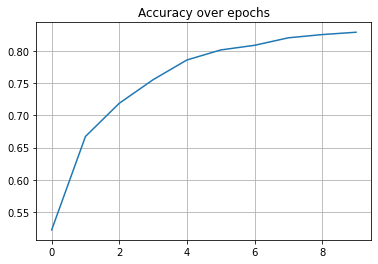



**Training epoch for hidden layer 4 **

(60000, 784) (60000, 10)

>epoch=0, lrate=0.010, error=0.086, acc=0.549

>epoch=1, lrate=0.010, error=0.068, acc=0.634

>epoch=2, lrate=0.010, error=0.060, acc=0.665

>epoch=3, lrate=0.010, error=0.054, acc=0.695

>epoch=4, lrate=0.010, error=0.050, acc=0.721

>epoch=5, lrate=0.010, error=0.046, acc=0.750

>epoch=6, lrate=0.010, error=0.043, acc=0.772

>epoch=7, lrate=0.010, error=0.040, acc=0.782

>epoch=8, lrate=0.010, error=0.038, acc=0.787

>epoch=9, lrate=0.010, error=0.038, acc=0.791

Train Accuracy: 0.7908333333333334

Test Accuracy: 0.7896

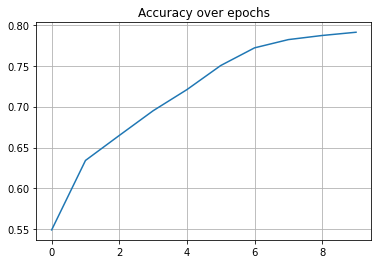

# Part 2: Training an Image Classifier




##Overview
CIFAR10 dataset will be used to train an image classifier.

![](https://miro.medium.com/max/578/1*BCsHErqOJxmKDLQXYJR_ow.png)



##Data
Using `torchvision`, it’s extremely easy to load `CIFAR10`.

In [ ]:
## The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


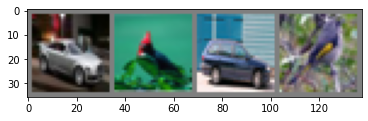

car   bird  car   bird 


In [ ]:
## Let us show some of the training images, for fun.

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##Code

###Define a Convolutional Neural Network

Create a neural network that take 3-channel images. It should go as Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## TODO: Add layers to your neural net.
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 8, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

        self.head = nn.Sequential(
            nn.Linear(16 * 25, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        ## TODO: run forward pass as mentioned above.
        x = self.backbone(x)
        x = x.view(-1, 16 * 25)
        x = self.head(x)

        return x


net = Net()

###Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum. (Feel free to experiment with other loss functions and optimizers to observe differences)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.3)

###Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
epochs = 30 ## TODO: define number of epochs to train
loss_lst = []
acc_lst = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    train_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # TODO: add line to zero the parameter gradients below
        optimizer.zero_grad()

        total += len(inputs)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        for j in range(len(inputs)):
          if preds[j] == labels[j]:
            correct += 1

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, acc: {correct / total}')
            running_loss = 0.0
    loss_lst.append(train_loss)
    acc_lst.append(correct / total)

print('Finished Training')

## Let’s quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.301, acc: 0.112125
[1,  4000] loss: 2.286, acc: 0.127625
[1,  6000] loss: 2.228, acc: 0.15070833333333333
[1,  8000] loss: 2.106, acc: 0.17659375
[1, 10000] loss: 2.032, acc: 0.1952
[1, 12000] loss: 1.958, acc: 0.21277083333333333
[2,  2000] loss: 1.833, acc: 0.335875
[2,  4000] loss: 1.737, acc: 0.3531875
[2,  6000] loss: 1.686, acc: 0.364625
[2,  8000] loss: 1.643, acc: 0.37203125
[2, 10000] loss: 1.629, acc: 0.378025
[2, 12000] loss: 1.592, acc: 0.3843958333333333
[3,  2000] loss: 1.546, acc: 0.4385
[3,  4000] loss: 1.532, acc: 0.43875
[3,  6000] loss: 1.507, acc: 0.44295833333333334
[3,  8000] loss: 1.463, acc: 0.44965625
[3, 10000] loss: 1.458, acc: 0.4543
[3, 12000] loss: 1.429, acc: 0.4586458333333333
[4,  2000] loss: 1.407, acc: 0.489625
[4,  4000] loss: 1.362, acc: 0.499875
[4,  6000] loss: 1.378, acc: 0.49966666666666665
[4,  8000] loss: 1.350, acc: 0.5035
[4, 10000] loss: 1.349, acc: 0.5058
[4, 12000] loss: 1.341, acc: 0.5078541666666667
[5,  2000] loss: 1

###Test the network on the test data
We have trained the network over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

confusion_matrix = np.zeros((10, 10))

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            confusion_matrix[label, prediction] += 1
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.5 %
Accuracy for class: car   is 74.3 %
Accuracy for class: bird  is 52.0 %
Accuracy for class: cat   is 58.8 %
Accuracy for class: deer  is 47.6 %
Accuracy for class: dog   is 45.5 %
Accuracy for class: frog  is 70.9 %
Accuracy for class: horse is 71.3 %
Accuracy for class: ship  is 74.9 %
Accuracy for class: truck is 74.9 %


<ipython-input-13-423e84548ef4>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.astype(np.int), figsize=(10, 10), cmap=plt.cm.PuBu)


Text(0, 0.5, 'GT')

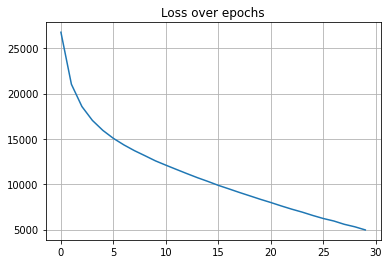

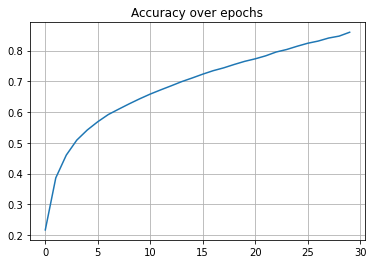

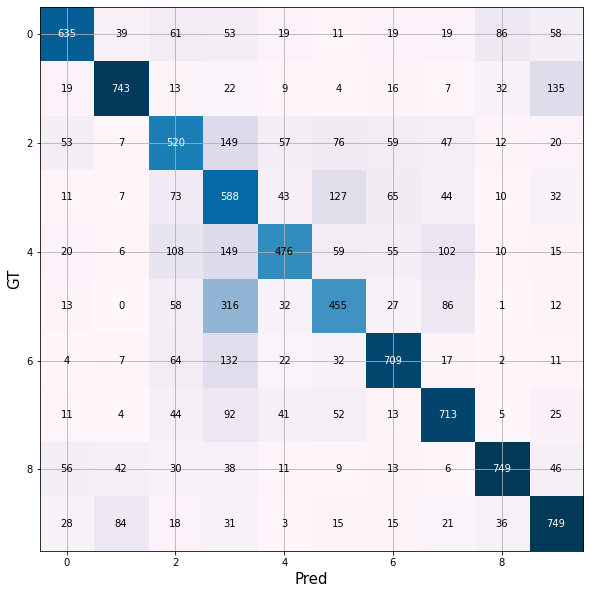

In [ ]:
plt.figure()
plt.grid()
plt.title("Loss over epochs")
plt.plot(np.arange(30), loss_lst)

plt.figure()
plt.grid()
plt.title("Accuracy over epochs")
plt.plot(np.arange(30), acc_lst)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.astype(np.int), figsize=(10, 10), cmap=plt.cm.PuBu)
plt.grid()
plt.xlabel("Pred", fontsize=15)
plt.ylabel("GT", fontsize=15)

## Write-up
**(1 pt) Show plot for loss over epochs.**

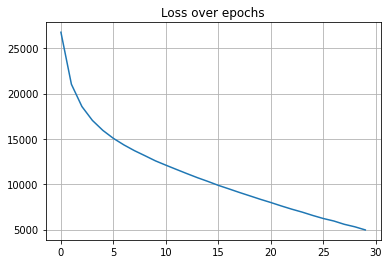





**(1 pt) Show plot for accuracy over epochs.**

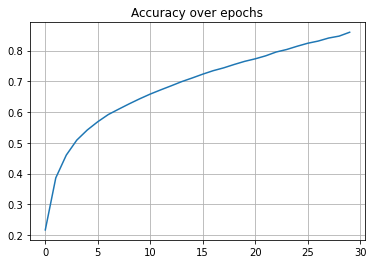

**(3 pt) Show confusion matrix on test data.**

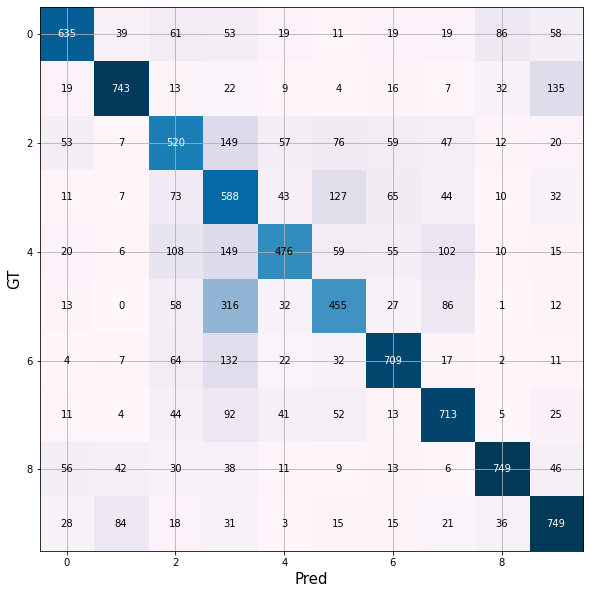

# Part 3: Semantic Segmentation

## Overview
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.
So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import os
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path

  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")

get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

"""Various RGB palettes for coloring segmentation labels."""
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

## Code

### 1. Implement Data Loader for training and validation

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# You can modify this class
class VocDataset(Dataset):
  def __init__(self, dir, color_map, dataset="trainval"):
    self.root=os.path.join(dir,'VOCdevkit/VOC2007')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    if dataset == "train":
      file_list = os.path.join(self.root,'ImageSets/Segmentation/train.txt')
    elif dataset == "val":
      file_list = os.path.join(self.root,'ImageSets/Segmentation/val.txt')
    else:
      file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map=np.array(color_map)

    self.img_lst = []
    self.anno_lst = []
    for f in self.files:
      img_path = os.path.join(self.images_dir, f + ".jpg")
      anno_path = os.path.join(self.target_dir, f + ".png")

      # img = np.array(cv2.imread(img_path), dtype=np.uint8)
      # anno = np.array(cv2.imread(anno_path), dtype=np.uint8)

      img = np.array(Image.open(img_path), dtype=np.float) / 255
      anno = np.array(Image.open(anno_path), dtype=np.uint8)
      img = img.transpose(2, 0, 1)
      anno[anno==255] = 0

      self.img_lst.append(img)
      self.anno_lst.append(anno)

  def __getitem__(self,index):

    return self.img_lst[index], self.anno_lst[index]

  def __len__(self):
    return len(self.files)

def convert_to_segmentation_mask(mask):
  # This function converts color channels of semgentation masks to number of classes
  # Semantic Segmentation requires a segmentation mask to be a NumPy array with the shape
  # This part is implemented for displaying colorized results in subpart 3
  # YOUR CODE HERE:

  out = np.zeros((mask.shape[0], mask.shape[1], 3))

  for i, c in enumerate(VOC_COLORMAP):
    out[(mask==i)] = c

  return np.array(out, dtype=np.int)

###2. Define model and training code
Implement FCN-32 model. You can use encoder as pretrained model provided by torchvision.       

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

def get_upsampling_weight(in_channels, out_channels, kernel_size):
  """Make a 2D bilinear kernel suitable for upsampling"""
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5
  og = np.ogrid[:kernel_size, :kernel_size]
  filt = (1 - abs(og[0] - center) / factor) * \
          (1 - abs(og[1] - center) / factor)
  weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                    dtype=np.float64)
  weight[range(in_channels), range(out_channels), :, :] = filt
  return torch.from_numpy(weight).float()


class FCN32(torch.nn.Module):
  def __init__(self, n_class=21, encoder=torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)):
    super(FCN32, self).__init__()

    self.encoder = encoder.features
    self.encoder[0].padding = (100, 100)
    self.encoder[4].ceil_mode = True
    self.encoder[9].ceil_mode = True
    self.encoder[16].ceil_mode = True
    self.encoder[23].ceil_mode = True
    self.encoder[30].ceil_mode = True

    # fc6
    self.fc6 = nn.Conv2d(512, 4096, 7)
    self.relu6 = nn.ReLU(inplace=True)
    self.drop6 = nn.Dropout2d()

    # fc7
    self.fc7 = nn.Conv2d(4096, 4096, 1)
    self.relu7 = nn.ReLU(inplace=True)
    self.drop7 = nn.Dropout2d()

    self.score_fr = nn.Conv2d(4096, n_class, 1)
    self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32,
                                      bias=False)

    # self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        m.weight.data.zero_()
        if m.bias is not None:
          m.bias.data.zero_()
      if isinstance(m, nn.ConvTranspose2d):
        assert m.kernel_size[0] == m.kernel_size[1]
        initial_weight = get_upsampling_weight(
            m.in_channels, m.out_channels, m.kernel_size[0])
        m.weight.data.copy_(initial_weight)

  def forward(self, x):
    h = x.float()

    h = self.encoder(h)
    h = self.relu6(self.fc6(h))
    h = self.drop6(h)

    h = self.relu7(self.fc7(h))
    h = self.drop7(h)

    h = self.score_fr(h)

    h = self.upscore(h)
    h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()

    return h

def cross_entropy2d(input, target, weight=None, size_average=True):
  # input: (n, c, h, w), target: (n, h, w)
  n, c, h, w = input.size()
  # log_p: (n, c, h, w)
  log_p = F.log_softmax(input, dim=1)
  # log_p: (n*h*w, c)
  log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
  log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
  log_p = log_p.view(-1, c)
  # target: (n*h*w,)
  mask = target >= 0
  target = target[mask]
  loss = F.nll_loss(log_p, target, weight=weight, reduction='sum')
  if size_average:
    loss /= mask.data.sum()
  return loss

def _fast_hist(label_true, label_pred, n_class):
  mask = (label_true >= 0) & (label_true < n_class)
  hist = np.bincount(
    n_class * label_true[mask].numpy().astype(int) +
    label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
  return hist


def label_accuracy_score(label_trues, label_preds, n_class):
  """Returns accuracy score evaluation result.
    - overall accuracy
    - mean accuracy
    - mean IOU -- true positive / (true positive + false positive + false negative) per class
    - fwavacc
  """
  hist = np.zeros((n_class, n_class))
  for lt, lp in zip(label_trues, label_preds):
    hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
  acc = np.diag(hist).sum() / hist.sum()
  with np.errstate(divide='ignore', invalid='ignore'):
    acc_cls = np.diag(hist) / hist.sum(axis=1)
  acc_cls = np.nanmean(acc_cls)
  with np.errstate(divide='ignore', invalid='ignore'):
    iu = np.diag(hist) / (
        hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
    )
  mean_iu = np.nanmean(iu)
  freq = hist.sum(axis=1) / hist.sum()
  fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
  return acc, acc_cls, mean_iu, fwavacc

 Training code for the semantic segmentation model. Implment both training and validation parts.  

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

model = FCN32().cuda()

bs = 1
train_loader = DataLoader(VocDataset("/content/", VOC_COLORMAP, "trainval"), batch_size=bs, shuffle=True)
val_loader = DataLoader(VocDataset("/content/", VOC_COLORMAP, "val"), batch_size=1, shuffle=True)


criterion = cross_entropy2d ## TODO: Add loss function
optimizer = optim.Adam(model.parameters(), 1e-4) ## TODO: Add optimizer

epochs = 10
model.train()
for epoch in range(epochs):  # loop over the dataset multiple times
  running_loss = 0.0
  for (img, anno) in tqdm(train_loader):
    running_loss = 0.0
    optimizer.zero_grad()
    out = model(img.cuda())

    loss = criterion(out, anno.cuda())
    running_loss += loss.data.item()
    loss.backward()
    optimizer.step()

  print("training loss:", running_loss)

  if epoch % 5 == 0 or epoch == epochs - 1:

    model.eval()
    visualizations = []
    label_trues, label_preds = [], []
    running_loss = 0.0
    for (img, anno) in val_loader:

      # img, anno = Variable(img, volatile=True), Variable(anno)
      score = model(img.cuda())
      loss = criterion(score, anno.cuda())
      running_loss += loss.data.item()

      imgs = img.data.cpu()
      lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
      lbl_true = anno.data.cpu()

      for img, lt, lp in zip(imgs, lbl_true, lbl_pred):
        # img, lt = val_loader.dataset.untransform(img, lt)
        label_trues.append(lt)
        label_preds.append(lp)
        visualizations.append(img)

        # if len(visualizations) < 9:
        #     viz = fcn.utils.visualize_segmentation(
        #         lbl_pred=lp, lbl_true=lt, img=img, n_class=n_class,
        #         label_names=val_loader.dataset.class_names)
        #     visualizations.append(viz)
    print("val loss:", running_loss)
    metrics = label_accuracy_score(
        label_trues, label_preds, n_class=21)
    metrics = np.array(metrics)
    metrics *= 100
    print('''\
    Accuracy: {0}
    Accuracy Class: {1}
    Mean IoU: {2}
    FWAV Accuracy: {3}'''.format(*metrics))
    model.train()

<ipython-input-18-f283752c1046>:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.array(Image.open(img_path), dtype=np.float) / 255
100%|██████████| 422/422 [02:01<00:00,  3.47it/s]


training loss: 3.965665578842163
val loss: 241.1177440881729
    Accuracy: 75.01044130032913
    Accuracy Class: 4.761904761904762
    Mean IoU: 3.5719257762061494
    FWAV Accuracy: 56.26566304070123


100%|██████████| 422/422 [01:58<00:00,  3.57it/s]


training loss: 1.45476233959198


100%|██████████| 422/422 [01:58<00:00,  3.56it/s]


training loss: 0.6247116327285767


100%|██████████| 422/422 [01:58<00:00,  3.56it/s]


training loss: 1.3745932579040527


100%|██████████| 422/422 [01:58<00:00,  3.57it/s]


training loss: 0.8681976795196533


100%|██████████| 422/422 [01:58<00:00,  3.56it/s]


training loss: 0.5524266362190247
val loss: 147.20049193315208
    Accuracy: 79.90332915400091
    Accuracy Class: 15.467843869334102
    Mean IoU: 9.355773608886125
    FWAV Accuracy: 68.52508233425729


100%|██████████| 422/422 [01:57<00:00,  3.58it/s]


training loss: 0.3747662603855133


100%|██████████| 422/422 [01:57<00:00,  3.58it/s]


training loss: 0.21974650025367737


100%|██████████| 422/422 [01:57<00:00,  3.59it/s]


training loss: 1.4781396389007568


100%|██████████| 422/422 [01:57<00:00,  3.58it/s]


training loss: 0.3115946054458618
val loss: 100.43224275391549
    Accuracy: 85.87078045506694
    Accuracy Class: 34.02548969579649
    Mean IoU: 25.067195390995618
    FWAV Accuracy: 77.03584826563932


### 3. Inference for semantic segmentation

Implement the inference code for semantic segmentation. Display the visualization results of each three model. Plot the image and colorized image (similar to the results in overview).

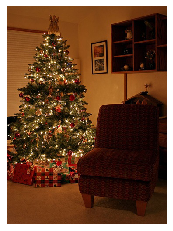

<ipython-input-18-f283752c1046>:55: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(out, dtype=np.int)


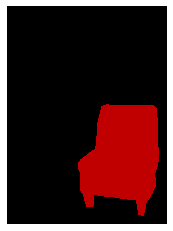

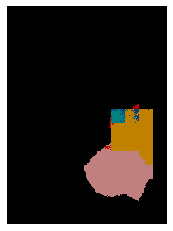

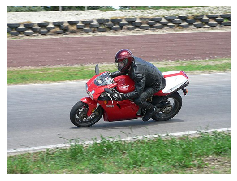

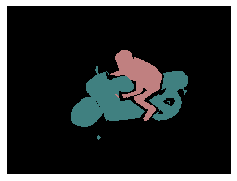

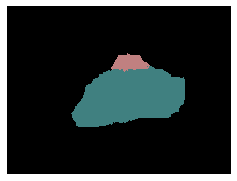

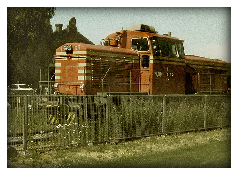

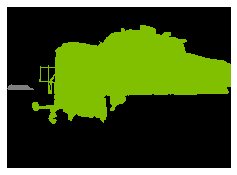

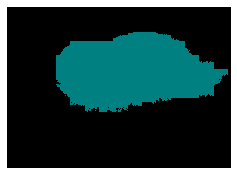

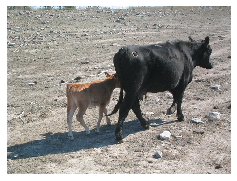

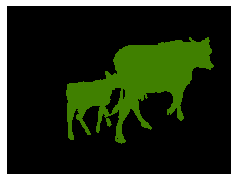

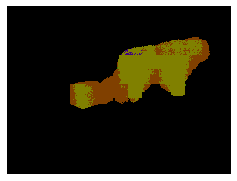

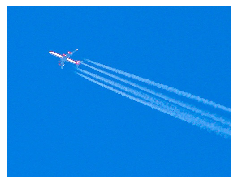

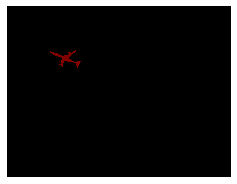

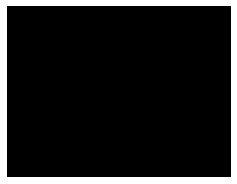

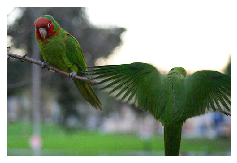

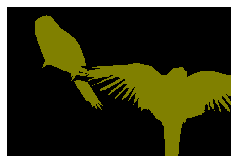

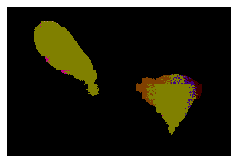

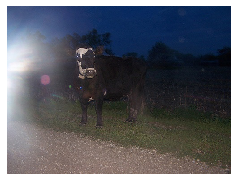

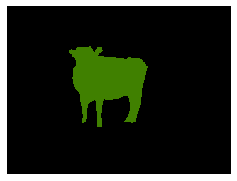

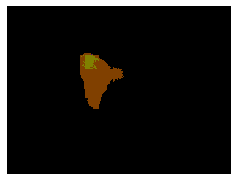

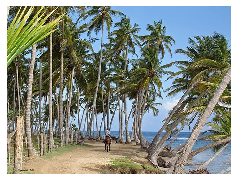

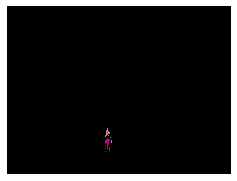

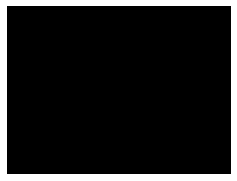

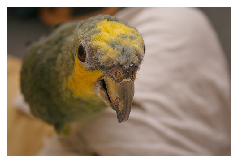

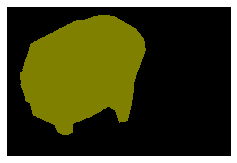

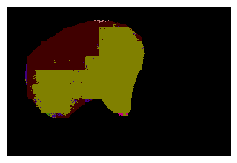

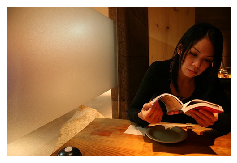

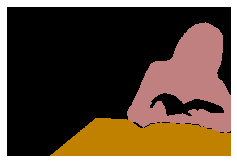

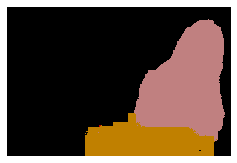

In [ ]:
# YOUR CODE HERE:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

for i in range(10):
  show_image(visualizations[i].numpy().transpose(1, 2, 0))
  show_image(convert_to_segmentation_mask(label_trues[i]))
  show_image(convert_to_segmentation_mask(label_preds[i]))

## Write-up
**Describe the properties of segmentation model**

FCNs, or Fully Convolutional Networks, are an architecture mostly employed for semantic segmentation. They only utilize locally connected layers, including convolution, pooling, and upsampling. Avoiding dense layers reduces the number of parameters (making the networks faster to train). It also implies that an FCN can function with varying image sizes providing that all connections are local. A downsampling approach is utilized to extract and understand context, whereas an upsampling path enables localisation. FCNs additionally use skip connections to retrieve the fine-grained spatial information that was lost during the downsampling process.FCNet model first shrink the feature size and later do the predictions by the head, which is very efficient.

**Describe the evaluation metric (IoU) for segmentation model**


The Intersection over Union (IoU) statistic, commonly known as the Jaccard index, measures the percentage of overlap between the target mask and our forecast output. This metric is closely connected to the Dice coefficient, which is frequently employed as a training loss function. IoU is calculated by dividing the number of shared pixels between the target and prediction masks by the total number of pixels present in both masks.

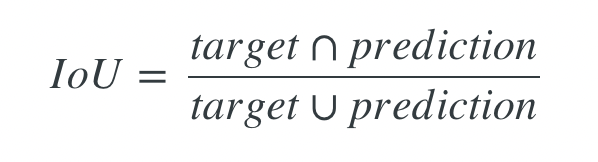


It is the intersection area of the ground truth and predicted label, over the union area of the ground truth and predicted label.

## References
* Refer to original paper FCNet : https://arxiv.org/abs/1411.4038
* Figures for FCNet Structure: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
* PyTorch Tutorial for Image semgnetation: https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f

# Part 4: Text2Img Generation

We have provided link to 'DALL.E' mini model to generate images from a text prompt in an interactive way.

https://colab.research.google.com/github/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb#scrollTo=118UKH5bWCGa